# 2D Tuned Alexnet Training Script

Here the original 2D AlexNet model is tuned in order to improve model performance.

This data has been preprocessed using the normalization range of -1100, 600.

In [1]:
import tensorflow as tf
import numpy as np
import keras
from keras.models import load_model
from tensorflow.python.keras.layers import Flatten, Conv2D, MaxPooling2D, Dropout, Input, Dense, Activation, BatchNormalization
from tensorflow.python.keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
training_images_final = np.load("2d_training_data_2.npy")
training_labels = np.load("2d_training_labels_2.npy")
testing_images_final = np.load("2d_testing_data_2.npy")
testing_labels = np.load("2d_testing_labels_2.npy")

The callbacks are defined below.

Early stopping monitors validation loss and automatically quits the training process if the validation loss has remained constant/has increased for 5 consecutive epochs. 

Model checkpoint saves the model that performs the best on the validation dataset.

Lr_reduction reduces the learning rate by a factor of 0.1 every time the validation loss has remained constant/has increased for 2 consecutive epochs.

In [3]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
model_checkpoint = ModelCheckpoint(filepath='2d_alexnet_adam.h5', monitor='val_loss', save_best_only=True, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.1, min_lr=0.00001)

The model is implemented and trained below. Training logs were preserved.

The following changes were made in an attempt to tune the model:

Batch size = 32 (vs 128)

Learning rate = 0.001 (vs 0.01)

Optimizer = Adam (vs SGD + momentum)

Regularization (l2) removed

After various experimentations, it was found that the combination of parameters specified above works best for this dataset.

In [4]:
batch_size = 32
no_epochs = 50
learning_rate = 0.001
no_classes = 2
validation_split = 0.15
verbosity = 1
X_train = training_images_final
callbacks = [early_stopping, model_checkpoint, lr_reduction]
    
def build_model():
    
    model = Sequential()

    model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    model.add(Flatten())

    model.add(Dense(4096, input_shape=(227*227*3,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(no_classes, activation='softmax'))
    
    return model

In [5]:
model = build_model()

model.compile(loss=keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['acc'])

history = model.fit(training_images_final, training_labels,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split,
            callbacks=callbacks)

Train on 9979 samples, validate on 1762 samples
Epoch 1/50
9952/9979 [============================>.] - ETA: 0s - loss: 0.4705 - acc: 0.7955
Epoch 00001: val_loss improved from inf to 0.31575, saving model to 2d_alexnet_adam.h5
9979/9979 [==============================] - 81s 8ms/sample - loss: 0.4698 - acc: 0.7958 - val_loss: 0.3157 - val_acc: 0.8695
Epoch 2/50
9952/9979 [============================>.] - ETA: 0s - loss: 0.3444 - acc: 0.8601
Epoch 00002: val_loss did not improve from 0.31575
9979/9979 [==============================] - 81s 8ms/sample - loss: 0.3444 - acc: 0.8601 - val_loss: 0.3885 - val_acc: 0.8280
Epoch 3/50
9952/9979 [============================>.] - ETA: 0s - loss: 0.3028 - acc: 0.8766
Epoch 00003: val_loss improved from 0.31575 to 0.25716, saving model to 2d_alexnet_adam.h5
9979/9979 [==============================] - 83s 8ms/sample - loss: 0.3029 - acc: 0.8767 - val_loss: 0.2572 - val_acc: 0.8978
Epoch 4/50
9952/9979 [============================>.] - ETA: 0s - 

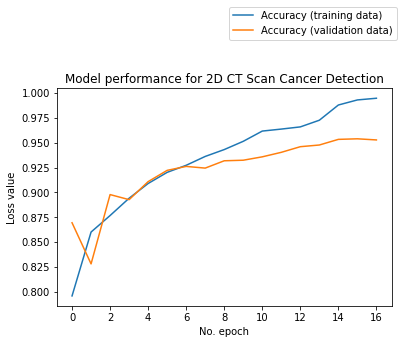

In [6]:
plt.plot(history.history['acc'], label='Accuracy (training data)')
plt.plot(history.history['val_acc'], label='Accuracy (validation data)')
plt.title('Model performance for 2D CT Scan Cancer Detection')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="lower left", bbox_to_anchor=(0.5,1.2))
plt.show()

The model has now been trained. It is then tested on unseen data in order to obtain the final testing accuracy.

In [7]:
test_results = model.evaluate(testing_images_final, testing_labels, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

2936/2936 [==============================] - 4s 1ms/sample - loss: 0.3072 - acc: 0.9421
Test results - Loss: 0.3071977539414322 - Accuracy: 94.2098081111908%


Finally, further performance metrics are evaluated using the functions below. These metrics are:

Sensitivity: The ability of the model to classify a nodule as malignant when it is actually malignant (TP / (TP+FN))

Specificity: The ability of the model to classify a nodule as benign when it is actually benign (TN/ (TN+FP))

Precision: The accuracy of the model with regards to identifying malignant cases (i.e., how many of the predicted malignant nodules are actually malignant?) 
(TP / (TP+FP))

In [8]:
# parameters:
# arg1: labels: a list of one-hot encoded binary vectors corresponding to the actual labels of the testing data
# arg2: positive: True for positive labels (i.e. malignant), False for negative labels (i.e. benign)

# returns: 
# the number of malignant or benign cases in a one-hot encoded testing labels array

def get_true_labels(labels,positive=True):
    count = 0
    if positive == True:
        for x in labels:
            if x[1] == 1:
                count += 1
    else:
        for x in labels:
            if x[1] == 0:
                count += 1
    return count

# parameters:
# arg1: actual_labels: a list of one-hot encoded binary vectors corresponding to the actual labels of the testing data
# arg2: predicted_labels: a list of integers corresponding to the predictions of the model on the testing data (0=benign, 1=cancer)

# returns: 
# the sensitivity of the model, defined as (TP / (TP+FN))

def get_sensitivity(actual_labels, predicted_labels):
    total_positives = get_true_labels(actual_labels)
    true_positives = 0
    for i in range(len(predicted_labels)):
        if list(actual_labels[i]) == [0,1] and predicted_labels[i] == 1:
            true_positives += 1
    return true_positives/total_positives

# parameters:
# arg1: actual_labels: a list of one-hot encoded binary vectors corresponding to the actual labels of the testing data
# arg2: predicted_labels: a list of integers corresponding to the predictions of the model on the testing data (0=benign, 1=cancer)

# returns: 
# the specificity of the model, defined as (TN/ (TN+FP))

def get_specificity(actual_labels, predicted_labels):
    total_negatives = get_true_labels(actual_labels, False)
    true_negatives = 0
    for i in range(len(predicted_labels)):
        if list(actual_labels[i]) == [1,0] and predicted_labels[i] == 0:
            true_negatives += 1
    return true_negatives/total_negatives

# parameters:
# arg1: actual_labels: a list of one-hot encoded binary vectors corresponding to the actual labels of the testing data
# arg2: predicted_labels: a list of integers corresponding to the predictions of the model on the testing data (0=benign, 1=cancer)

# returns: 
# the precision of the model, defined as (TP / (TP+FP))

def get_precision(actual_labels, predicted_labels):
    true_positives = 0
    false_positives = 0
    for i in range(len(predicted_labels)):
        if list(actual_labels[i]) == [0,1] and predicted_labels[i] == 1:
            true_positives += 1
        if list(actual_labels[i]) == [1,0] and predicted_labels[i] == 1:
            false_positives += 1
    return true_positives/(true_positives+false_positives)

The list of model predictions is obtained and, along with the actual labels, is used to derive the performance metrics of the model.

In [9]:
predicted_labels = model.predict_classes(testing_images_final)

In [10]:
sensitivity = get_sensitivity(testing_labels, predicted_labels)
specificity = get_specificity(testing_labels, predicted_labels)
precision = get_precision(testing_labels, predicted_labels)
print(sensitivity, specificity, precision)

0.9665970772442589 0.8960784313725491 0.9458631256384066


In [11]:
f= open("2D_AlexNet_Results_Opt.txt","w+")
f.write("2D AlexNet Performance Metrics\n")
f.write("Loss: {0}\n".format(test_results[0]))
f.write("Accuracy: {0}\n".format(test_results[1]*100))
f.write("Sensitivity: {0}\n".format(sensitivity))
f.write("Specificity: {0}\n".format(specificity))
f.write("Precision: {0}\n".format(precision))
f.close()